In [1]:
# coding='utf-8'
# Imports
from bs4 import BeautifulSoup
from datetime import datetime
from matplotlib.ticker import FuncFormatter
from scipy import spatial
from scipy.interpolate import interp1d
import argparse
import csv
import errno
import json
import locale
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import re

import rotinas as rtn

"""Lê dados de parlamentares de arquivos CSV e
gera gráficos, texto e páginas com o conteúdo
"""

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

In [2]:
# Lê legislatura e Lista de anos de mandato para contabilização
with open('csv/anos.csv', newline='') as arquivoAnos:
    anosReader = csv.reader(arquivoAnos)
    for row in anosReader:
        # Ignora o header (se houver)
        if rtn.maiorQue(row[0]) and rtn.maiorQue(row[1]) and rtn.maiorQue(row[2]):
            legislaturaAtual = int(row[0])
            anos = list(range(int(row[1]), int(row[2]) + 1))
            # Quarto campo está no formato aaaa-mm-dd hh:mm:ss.dcmm
            # Primeiro separa data de hora
            dataColeta, horaColeta = row[3].split(' ')
            # Muda data coleta de aaaa-mm-dd para dd/mm/aaaa
            dataColeta = dataColeta.split('-')
            dataColeta = dataColeta[2] + '/' + \
                dataColeta[1] + '/' + dataColeta[0]
            # Descarta os décimos de segundo
            horaColeta = horaColeta.split('.')[0]
            break

In [3]:
# Lê créditos das fotos
# Ao fim, listaCredito[codigo] = credito para senador[codigo]
with open('csv/creditos.csv', newline='') as creditos:
    creditosReader = csv.reader(creditos)
    header = next(creditosReader)
    listaCredito = {}
    for row in creditosReader:
        listaCredito[int(row[0].split('.')[0].replace('senador', ''))] = row[1]

In [4]:
# Lê DataFrames
dadosSenado = pd.read_csv('csv/senado.csv', encoding='utf-8', index_col=0)
top = pd.read_csv('csv/top.csv', encoding='utf-8')
gastoPartidos = pd.read_csv('csv/gastoPartidos.csv',
                            encoding='utf-8', index_col=0)
gastoEstados = pd.read_csv('csv/gastoEstados.csv',
                           encoding='utf-8', index_col=0)
#sexo = pd.read_csv('csv/sexo.csv', encoding='utf-8')
sexo = dadosSenado.rename(columns={'Participacao': '(Sexo, Situação)'}).groupby(
    ['sexo', 'status'])['(Sexo, Situação)'].count()
sexoT = pd.read_csv('csv/sexoT.csv', encoding='utf-8', index_col=0)

In [6]:
# Lê arquivo json de gastos de senadores
with open('json/gastosSenadores.json', 'r', encoding='utf-8') as entrada:
    gastosSenadores = json.load(entrada)
entrada.close()

# Lê arquivo json de gastos do senado
with open('json/gastosSenado.json', 'r', encoding='utf-8') as entrada:
    gastosSenado = json.load(entrada)
entrada.close()

In [7]:
# Calcula dados importantes
totalSenadores = len(dadosSenado)
totalHomens = len(dadosSenado[dadosSenado.sexo == 'Masculino'])
totalMulheres = len(dadosSenado[dadosSenado.sexo == 'Feminino'])
totalExercicio = len(dadosSenado[dadosSenado.status == 'Exercicio'])
totalMulheresExercicio = dadosSenado.query(
    'sexo == "Feminino" and status == "Exercicio"').count()[0]
totalForaExercicio = len(dadosSenado[dadosSenado.status == 'ForaExercicio'])
totalGasto = dadosSenado['gastos'].sum()

# Não contabiliza parlamentares que ainda não efetuaram gastos no cálculo de médias
gastoMedioSenadores = dadosSenado.query('gastos != 0')['gastos'].mean()
mediaGastosHomensExercicio = dadosSenado.query(
    'gastos != 0 and sexo == "Masculino" and status == "Exercicio"')['gastos'].mean()
mediaGastosMulheresExercicio = dadosSenado.query(
    'gastos !=0 and sexo == "Feminino" and status == "Exercicio"')['gastos'].mean()

In [8]:
# Imprime algumas informações do senado, pelos dados coletados
print('Há no senado {:d} senadores, distribuidos entre {:d} homens e {:d} mulheres'.format(
    totalSenadores, totalHomens, totalMulheres))
print('As mulheres representam ' + locale.format('%.2f',
                                                 totalMulheres / totalSenadores * 100) + '% do total')
print('Há {:d} senadores em exercício, destes {:d} são mulheres'.format(
    totalExercicio, totalMulheresExercicio))
print('As mulheres representam ' + locale.format('%.2f',
                                                 totalMulheresExercicio / totalExercicio * 100) + '% deste total')
print('O gasto médio de senadores homens em exercício foi de ' +
      rtn.reais(mediaGastosHomensExercicio))
print('O gasto médio de senadores mulheres em exercício foi de ' +
      rtn.reais(mediaGastosMulheresExercicio))
print('O gasto médio dos senadores, em exercício e fora de exercício, foi de ' +
      rtn.reais(gastoMedioSenadores))
print('O montante de despesas parlamentares em {:d} anos foi de {}, com media anual de {}\n'.format(
    len(anos), rtn.reais(totalGasto), rtn.reais(totalGasto / len(anos))))

print('Gastos do senado por tema:')
totalizacaoGastosSenado = 0.0
for caput in gastosSenado:
    totalizacaoGastosSenado += gastosSenado[caput]
    print('{}: {}'.format(caput, rtn.reais(round(gastosSenado[caput], 2))))

print('Total de gastos: {}'.format(rtn.reais(round(totalizacaoGastosSenado, 2))))

Há no senado 119 senadores, distribuidos entre 105 homens e 14 mulheres
As mulheres representam 11,76% do total
Há 81 senadores em exercício, destes 13 são mulheres
As mulheres representam 16,05% deste total
O gasto médio de senadores homens em exercício foi de R$ 1.172.066,69
O gasto médio de senadores mulheres em exercício foi de R$ 1.122.171,65
O gasto médio dos senadores, em exercício e fora de exercício, foi de R$ 961.693,02
O montante de despesas parlamentares em 4 anos foi de R$ 101.939.460,46, com media anual de R$ 25.484.865,12

Gastos do senado por tema:
Aluguel de imóveis para escritório político: R$ 16.489.658,62
Aquisição de material de consumo: R$ 3.027.975,29
Locomoção, hospedagem, alimentação, combustíveis e: R$ 19.287.390,62
Divulgação da atividade parlamentar: R$ 11.866.405,91
Passagens aéreas, aquáticas e terrestres nacionais: R$ 21.626.326,41
Diárias: R$ 2.072.919,20
Combustíveis: R$ 1.012.498,01
Outros materiais: R$ 1.286.763,98
Correios: R$ 10.352.935,65
Contrataç

In [9]:
def meses(anos):
    """Retorna o total de meses desde o início da legislatura até a data da coleta
    """
    #hoje = datetime.today()
    mesColeta = int(dataColeta.split('/')[1])
    #diaAtual = hoje.day                # 1 <= day <= número de dias do mês
    pesos = np.full(len(anos), 12, dtype=int)
    pesos[0] = 11                       # Desconta 1 do primeiro ano, porque a legislatura começa em fevereiro
    pesos[len(anos)-1] = mesColeta      # Contabiliza o último ano pelo mês atual
    return np.sum(pesos), pesos         # retorna o total de meses e os meses em cada ano


numMeses, pesosMeses = meses(anos)      # Usado para ponderar os gastos totais e gastos com gabinete

In [10]:
# Cria grafo de senadores
grafo = {'nodes': [], 'links': []}

links = 0
reverso = {}
gabinete = 'Uso de Gabinete'
moradia = 'Uso de benefícios de moradia'

# Cria os nós dos gastos
for gasto in gastosSenado:
    grafo['nodes'].append({
        'id': links,
        'tipo': 'gasto',
        'nome': gasto,
        'uso': round(gastosSenado[gasto], 2)
        })
    reverso[gasto] = links
    links += 1

# Cria os nós de uso de Gabinete e Moradia
grafo['nodes'].append({
    'id': links,
    'tipo': 'gasto',
    'nome': gabinete,
    'uso': 0.0
    })
reverso[gabinete] = links
links += 1
grafo['nodes'].append({
    'id': links,
    'tipo': 'gasto',
    'nome': moradia,
    'uso': 0.0
    })
reverso[moradia] = links
links += 1

In [11]:
vetores = []

totalMoradia = 0.0
totalGabinete = 0.0

for i in range(len(gastosSenadores)):
    # print(i, links+i)
    # senador -> índice para o senador no df dadosSenado
    # infoSenador -> dados do senador no df dadosSenado
    senador = gastosSenadores[i]['senador']
    infoSenador = dadosSenado.loc[senador]
    gastos = 0.0
    tipoGastos = {}

    # Computa o total de gastos (gastos) e o parcial em cada etiqueta (tipoGastos)
    # de um senador
    for g in range(len(gastosSenadores[i]['gastos'])):
        gastos += gastosSenadores[i]['gastos'][g]['total']
        for tipo in gastosSenadores[i]['gastos'][g]['lista']:
            if tipo in tipoGastos:
                tipoGastos[tipo] += round(gastosSenadores[i]['gastos'][g]['lista'][tipo], 2)
            else:
                tipoGastos[tipo] = round(gastosSenadores[i]['gastos'][g]['lista'][tipo], 2)

    senadorGabinete = 0.0
    senadorMoradia = 0.0

    for ano in anos:
        senadorGabinete += infoSenador[f'TotalGabinete-{ano}'] * pesosMeses[ano-anos[0]]
        senadorMoradia += (infoSenador[f'Imóvel Funcional-{ano}'] + infoSenador[f'Auxílio-Moradia-{ano}']) # * pesosMeses[ano-anos[0]]

    # Converte utilização de gabinete e moradia para uma estimativa de custo
    senadorGabinete *= 10000
    senadorMoradia *= 5500

    if (senadorGabinete > 0.0):
        tipoGastos[gabinete] = senadorGabinete
    if (senadorMoradia > 0.0):
        tipoGastos[moradia] = senadorMoradia
    # Acumula os totais de gabinete e moradia
    totalGabinete += senadorGabinete
    totalMoradia += senadorMoradia
    # Soma gastos, gabinete e moradia e
    # pondera pelo número de meses da legislatura
    recursos = round(gastos + senadorGabinete + senadorMoradia, 2)

    if (recursos > 1000):
        # Cria vetor de utilização de recursos
        vetor = []
        for gastos in gastosSenado:
            if gastos in tipoGastos:
                vetor.append(round(tipoGastos[gastos],2))
            else:
                vetor.append(0.0)

        vetores.append({'id': i + links, 'vetor': list(vetor)})
        reverso[i + links] = len(grafo['nodes'])

        # Cria o nó do senador
        grafo['nodes'].append({
            'id': i + links,
            'tipo': 'senador',
            'uso': recursos,
            'nome': infoSenador.nome,
            'partido': infoSenador.partido,
            'estado': infoSenador.UF,
            'sexo': infoSenador.sexo,
            'status': infoSenador.status,
            'participacao': infoSenador.Participacao
            # 'vetor': vetor
            })

        # Cria os links do senador para o nós dos gastos
        for tipo in tipoGastos:
            grafo['links'].append({
                'source': i + links,
                'target': reverso[tipo],
                'weight': round(tipoGastos[tipo], 2)
                })

In [16]:
vetores[0]['vetor']

[239395.87,
 7486.18,
 492799.54,
 174805.59,
 320108.77,
 11340.64,
 12281.28,
 15759.4,
 55224.31,
 27468.0,
 0.0,
 0.0]

In [15]:
tipoGastos

{'Combustíveis': 180.95,
 'Locomoção, hospedagem, alimentação, combustíveis e': 1608.33,
 'Outros materiais': 183.74,
 'Passagens aéreas, aquáticas e terrestres nacionais': 9689.92}

In [12]:
# Preenche o gasto estimado de auxílio moradia e gabinete
grafo['nodes'][reverso[gabinete]]['uso'] = totalGabinete
grafo['nodes'][reverso[moradia]]['uso'] = totalMoradia
similaridade = 0.96

# Cria links entre os senadores que possuem similaridades de utilização
# de recursos (similaridade de cosseno > args.similaridade [defaul > 0.95])
interpolacao = interp1d([1, similaridade], [10, 5])
for i in vetores:
    excentricidade = []
    for j in vetores:
        dist = 1 - spatial.distance.cosine(i['vetor'], j['vetor'])
        if i == j:
            excentricidade.append(0.0)
        else:
            excentricidade.append(dist);
        if (j['id'] > i['id']):
            # dist = 1 - spatial.distance.cosine(i['vetor'], j['vetor'])
            if dist > similaridade:
                grafo['links'].append({
                    'source': i['id'],
                    'target': j['id'],
                    'weight': round(float(interpolacao(dist)), 2)
                    })
    grafo['nodes'][reverso[i['id']]]['excentricidade'] = round(1 - max(excentricidade), 5)

In [18]:
len(vetores[0]['vetor'])

12

In [17]:
'Passagens aéreas, aquáticas e terrestres nacionais' in tipoGastos

True

In [26]:
from scipy.interpolate import interp1d

In [27]:
interpolacao = interp1d([1, 0.95], [10, 5])

In [34]:
float(interpolacao(0.975))

7.5

3

In [16]:
numMeses, pesosMeses = meses(anos)  # Usado para ponderar os gastos totais e gastos com gabinete
grafo = {'nodes':[], 'links':[]}
args = {'custoGabinete': 25000, 'custoMoradia': 5500}
args

{'custoGabinete': 25000, 'custoMoradia': 5500}

In [47]:
grafo = {"nodes": [], "links": []}

links = 0
reverso = {}
gabinete = "Uso de Gabinete"
moradia = "Uso de benefícios de moradia"

# Cria os nós dos gastos
for gasto in gastosSenado:
    grafo['nodes'].append({
        "id": links,
        "tipo": "gasto",
        "nome": gasto,
        "uso": round(gastosSenado[gasto], 2)
        })
    reverso[gasto] = links
    links += 1

# Cria os nós de uso de Gabinete e Moradia
grafo['nodes'].append({
    "id": links,
    "tipo": "gasto",
    "nome": gabinete,
    "uso": 0.0
    })

reverso[gabinete] = links
links += 1
grafo['nodes'].append({
    "id": links,
    "tipo": "gasto",
    "nome": moradia,
    "uso": 0.0
    })
reverso[moradia] = links
links += 1
totalMoradia = 0.0
totalGabinete = 0.0
vetores = {}

# Cria grafo de senadores e
# grafo de partidos
for i in range(len(gastosSenadores)):
    # senador -> índice para o senador no df dadosSenado
    # infoSenador -> dados do senador no df dadosSenado
    senador = gastosSenadores[i]['senador']
    infoSenador = dadosSenado.loc[senador]
    gastos = 0.0
    tipoGastos = {}

    # Computa o total de gastos (gastos) e o parcial em cada etiqueta (tipoGastos)
    # de um senador
    for g in range(len(gastosSenadores[i]['gastos'])):
        gastos += gastosSenadores[i]['gastos'][g]['total']
        for tipo in gastosSenadores[i]['gastos'][g]['lista']:
            if tipo in tipoGastos:
                tipoGastos[tipo] += round(gastosSenadores[i]['gastos'][g]['lista'][tipo], 2)
            else:
                tipoGastos[tipo] = round(gastosSenadores[i]['gastos'][g]['lista'][tipo], 2)

    senadorGabinete = 0.0
    senadorMoradia = 0.0

    for ano in anos:
        senadorGabinete += infoSenador[f'TotalGabinete-{ano}'] * pesosMeses[ano-anos[0]]
        senadorMoradia += (infoSenador[f'Imóvel Funcional-{ano}'] + infoSenador[f'Auxílio-Moradia-{ano}']) # * pesosMeses[ano-anos[0]]

    # Converte utilização de gabinete e moradia para uma estimativa de custo
    senadorGabinete *= args['custoGabinete']
    senadorMoradia *= args['custoMoradia']
    if (senadorGabinete > 0.0):
        tipoGastos[gabinete] = senadorGabinete
    if (senadorMoradia > 0.0):
        tipoGastos[moradia] = senadorMoradia
    # Acumula os totais de gabinete e moradia
    totalGabinete += senadorGabinete
    totalMoradia += senadorMoradia
    # Soma gastos, gabinete e moradia e
    # pondera pelo número de meses da legislatura
    recursos = round(gastos + senadorGabinete + senadorMoradia, 2)

    if (recursos > 0.0):
        # Cria vetor de utilização de recursos
        vetor = []
        for gastos in gastosSenado:
            if gastos in tipoGastos:
                vetor.append(tipoGastos[gastos])
            else:
                vetor.append(0.0)
        vetores[i+links] = list(vetor)
        print(i+links, vetor)

        # Cria o nó do senador
        grafo['nodes'].append({
            "id": i + links,
            "tipo": "senador",
            "uso": recursos,
            "nome": infoSenador.nome,
            "partido": infoSenador.partido,
            "sexo": infoSenador.sexo,
            "status": infoSenador.status,
            "participacao": infoSenador.Participacao
            })

        # Cria os links do senador para o nós dos gastos
        for tipo in tipoGastos:
            grafo['links'].append({
                "source": i + links,
                "target": reverso[tipo],
                "weight": round(tipoGastos[tipo], 2)
                })
# Preenche o gasto estimado de auxílio moradia e gabinete
grafo['nodes'][reverso[gabinete]]["uso"] = totalGabinete
grafo['nodes'][reverso[moradia]]["uso"] = totalMoradia

14 [239395.87, 7486.18, 492799.54, 174805.59, 320108.77, 11340.64, 12281.279999999999, 15370.7, 55224.31, 27468.0, 0.0, 0.0]
15 [178078.84, 8442.14, 19172.04, 0.0, 55567.02, 0.0, 0.0, 5538.21, 18453.3, 57350.3, 0.0, 0.0]
16 [0.0, 0.0, 17529.89, 0.0, 348363.3, 0.0, 19526.1, 23271.690000000002, 82449.73000000001, 0.0, 0.0, 0.0]
17 [97164.41, 17538.1, 93911.7, 0.0, 220458.75, 30945.64, 14628.82, 12626.26, 183847.22999999998, 68900.0, 1939.31, 0.0]
18 [393204.46, 91960.56, 18916.87, 0.0, 270282.02, 109993.09, 9000.18, 18905.6, 94895.47, 217065.99, 0.0, 0.0]
19 [37086.0, 1443.8, 300975.27999999997, 316384.3, 216289.62999999998, 82909.07999999999, 13751.619999999999, 13105.7, 55366.740000000005, 129800.0, 0.0, 0.0]
20 [119668.62000000001, 17830.41, 38923.17, 231760.0, 215834.51, 0.0, 1932.79, 12002.029999999999, 54218.75, 117741.09999999999, 0.0, 0.0]
21 [40753.42, 0.0, 158272.57, 402277.68, 299032.58999999997, 0.0, 20208.44, 11552.46, 77749.65000000001, 55000.0, 0.0, 0.0]
22 [648342.93, 394

In [33]:
from scipy import spatial

In [44]:
for i in vetores:
    for j in vetores:
        if (j > i):
            dist = 1 - spatial.distance.cosine(vetores[i], vetores[j])
            if dist > 0.96:
                print(i, j, dist)

15 55 0.9709809593570231
15 62 0.9746753163682853
15 109 0.9673466546590896
16 105 0.9611031873700173
16 108 0.970079136908454
16 132 0.9652656159064685
19 50 0.9645956671962761
21 87 0.9858551047929305
21 125 0.9625506266590782
25 63 0.9785663970959088
25 85 0.9801865746038438
26 94 0.9773749848215361
27 29 0.9626768848035515
27 31 0.9777687751441377
27 43 0.9616111588081127
27 67 0.9752652761606403
27 71 0.9817937984600268
29 31 0.9744265679563844
29 71 0.9684674203695521
31 71 0.9873817501007893
32 125 0.9740431620746838
33 121 0.9658569384943388
34 128 0.9729365967184378
36 53 0.9746999677798991
36 56 0.9657584578777167
38 43 0.9621434036556981
38 53 0.961962519663997
38 64 0.9904114103005122
39 52 0.9670880796130796
40 42 0.9855677042343258
43 64 0.9652881653806138
43 71 0.9616165369611509
47 114 0.9634950497085414
49 87 0.9788173855304165
50 88 0.9822197850309893
53 64 0.9795361736086967
56 74 0.9812205843002364
56 90 0.9691487178572564
57 101 0.9859743694342834
60 118 0.98391730

In [17]:
grafo['nodes'][0]

{'id': 0,
 'nome': 'Aluguel de imóveis para escritório político',
 'tipo': 'gasto',
 'uso': 16479460.43}

In [18]:
grafo['nodes'][15]

{'id': 15,
 'nome': 'Airton Sandoval',
 'participacao': '1º Suplente',
 'partido': 'MDB',
 'sexo': 'Masculino',
 'status': 'Exercicio',
 'tipo': 'senador',
 'uso': 13119601.85}

In [19]:
grafo['links'][15]

{'source': 15, 'target': 9, 'weight': 57350.3}

In [20]:
print(f'Links: {len(grafo["links"])}, {grafo["links"][0]}')

Links: 1112, {'source': 14, 'target': 0, 'weight': 239395.87}


In [21]:
len(grafo['nodes'])

120

## Playground

In [25]:
from datetime import datetime
datetime.today().month

5

In [1]:
reverso

NameError: name 'reverso' is not defined

In [19]:
np.mean([1, 3, 5])

3.0

In [79]:
def meses(anos):
    """Retorna o total de meses desde o início da legislatura até a data atual
    """
    mesAtual = datetime.today().month
    pesos = np.full(len(anos), 12, dtype=int)
    pesos[0] = 11                   # Desconta 1 do primeiro ano, porque a legislatura começa em fevereiro
    pesos[len(anos)-1] = mesAtual   # Contabiliza o último ano pelo mês atual
    return np.sum(pesos), pesos     # retorna o total de meses e os meses em cada ano

In [81]:
total, porAno = meses(anos)
print(total, porAno)

40 [11 12 12  5]


In [29]:
grafo = {"nodes":[], "links":[]}

In [42]:
grafo

{'links': [], 'nodes': []}

In [301]:
test = 10.1234
print(f'test: {test:.2f}')
print('test {:.2f}'.format(test))

test: 10.12
test 10.12


In [22]:
def json2gml(dados, arquivo, directed=0, id="id", label="label", numero=[]):
    """Gera arquivo em formato GML, como no exemplo abaixo:
    graph [
        directed 1
        node [
            id 0
            label "Bleak House"
        ]
        node [
            id 1
            label "Oliver Twist"
        ]
        edge [
            source 0
            target 1
            weight 2
        ]
    ]
    """
    if not os.path.exists('gml'):
        os.makedirs('gml')

    with open(f'gml/{arquivo}', 'w', encoding='utf-8') as gml:
        # Starts with GDF header
        gml.write(f'graph [\n    directed {directed}\n')
        # Loops through nodes
        for no in dados['nodes']:
            gml.write('    node [\n')
            for campo in no:
                if campo == id:
                    gml.write(f'        id {no["id"]}\n')
                elif campo in numero:
                    gml.write(f'        {campo} {no[campo]}\n')
                elif campo == label:
                    gml.write(f'        label "{no[campo]}"\n')
                else:
                    gml.write(f'        {campo} "{no[campo]}"\n')
            gml.write('    ]\n')
        for vertice in dados['links']:
            gml.write('    edge [\n')
            for campo in vertice:
                gml.write(f'        {campo} {vertice[campo]}\n')
            gml.write('    ]\n')
        gml.write(']\n')
    gml.close()

In [6]:
# Lê arquivo json
with open('json/grafoSenado.json', 'r', encoding='utf-8') as entrada:
    grafo = json.load(entrada)
entrada.close()

In [7]:
gSenado = nx.Graph()

In [8]:
for no in grafo['nodes']:
    if no['tipo'] == 'gasto':
        gSenado.add_node(no['id'], label=no['nome'], uso=int(round(no['uso']*100)), tipo=no['tipo'])
    else:
        gSenado.add_node(no['id'], label=no['nome'], uso=int(round(no['uso']*100)), tipo=no['tipo'],
                         partido=no['partido'], sexo=no['sexo'], status=no['status'],
                         participacao=no['participacao'])

In [9]:
for vertice in grafo['links']:
    gSenado.add_edge(vertice['source'], vertice['target'], weight=int(round(vertice['weight'])))

In [10]:
%matplotlib inline

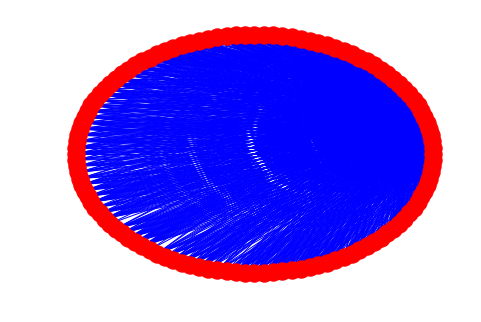

In [11]:
#plt.subplot(121)
#nx.draw(gSenado, edge_color='b')
#plt.subplot(121)
nx.draw(gSenado, pos=nx.circular_layout(gSenado), nodecolor='r', edge_color='b')

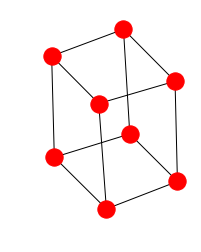

In [12]:
G = nx.cubical_graph()
plt.subplot(121)
nx.draw(G)

In [13]:
print(G.adj)

{0: {1: {}, 3: {}, 4: {}}, 1: {0: {}, 2: {}, 7: {}}, 2: {1: {}, 3: {}, 6: {}}, 3: {0: {}, 2: {}, 5: {}}, 4: {0: {}, 5: {}, 7: {}}, 5: {3: {}, 4: {}, 6: {}}, 6: {2: {}, 5: {}, 7: {}}, 7: {1: {}, 4: {}, 6: {}}}


In [31]:
nx.degree_centrality(gSenado)

{0: 0.7647058823529411,
 1: 0.6470588235294117,
 2: 0.8151260504201681,
 3: 0.6470588235294117,
 4: 0.8403361344537815,
 5: 0.453781512605042,
 6: 0.7815126050420168,
 7: 0.8655462184873949,
 8: 0.8655462184873949,
 9: 0.7394957983193277,
 10: 0.15126050420168066,
 11: 0.2184873949579832,
 12: 0.8403361344537815,
 13: 0.7142857142857143,
 14: 0.10084033613445378,
 15: 0.07563025210084033,
 16: 0.05042016806722689,
 17: 0.09243697478991596,
 18: 0.09243697478991596,
 19: 0.10084033613445378,
 20: 0.09243697478991596,
 21: 0.08403361344537814,
 22: 0.10084033613445378,
 23: 0.07563025210084033,
 24: 0.10084033613445378,
 25: 0.058823529411764705,
 26: 0.10084033613445378,
 27: 0.09243697478991596,
 28: 0.10084033613445378,
 29: 0.10084033613445378,
 30: 0.07563025210084033,
 31: 0.10084033613445378,
 32: 0.08403361344537814,
 33: 0.1092436974789916,
 34: 0.1092436974789916,
 35: 0.03361344537815126,
 36: 0.10084033613445378,
 37: 0.09243697478991596,
 38: 0.1092436974789916,
 39: 0.10924

In [32]:
print(gSenado.adj)

{0: {14: {'weight': 239396}, 15: {'weight': 178079}, 17: {'weight': 97164}, 18: {'weight': 393204}, 19: {'weight': 37086}, 20: {'weight': 119669}, 21: {'weight': 40753}, 22: {'weight': 648343}, 23: {'weight': 233147}, 24: {'weight': 10000}, 26: {'weight': 94762}, 27: {'weight': 134953}, 28: {'weight': 204833}, 29: {'weight': 110993}, 30: {'weight': 438945}, 31: {'weight': 180783}, 33: {'weight': 107501}, 34: {'weight': 224890}, 36: {'weight': 259041}, 38: {'weight': 234228}, 39: {'weight': 291605}, 40: {'weight': 153187}, 41: {'weight': 60352}, 42: {'weight': 226642}, 43: {'weight': 321752}, 44: {'weight': 203826}, 45: {'weight': 99279}, 47: {'weight': 268879}, 48: {'weight': 88587}, 49: {'weight': 35500}, 50: {'weight': 164856}, 51: {'weight': 148207}, 52: {'weight': 221630}, 53: {'weight': 130456}, 54: {'weight': 296659}, 55: {'weight': 242735}, 56: {'weight': 205168}, 57: {'weight': 332700}, 58: {'weight': 353129}, 59: {'weight': 102933}, 60: {'weight': 159743}, 61: {'weight': 13840

In [14]:
nx.pagerank(gSenado)

{0: 0.006982400822445237,
 1: 0.0023347108013214647,
 2: 0.008023505721436085,
 3: 0.005152320457628645,
 4: 0.011349680802127365,
 5: 0.0021167337993848374,
 6: 0.0016155205054527873,
 7: 0.002772668839878356,
 8: 0.005709761576704618,
 9: 0.005062437912939223,
 10: 0.0015938927444809226,
 11: 0.0017093430025438543,
 12: 0.4084551438851284,
 13: 0.006064928773858793,
 14: 0.0054277348721389895,
 15: 0.0028299210446515594,
 16: 0.004829223385904182,
 17: 0.0039635932588798755,
 18: 0.004102979554923699,
 19: 0.005213069870665835,
 20: 0.004615274055578593,
 21: 0.005617638225970241,
 22: 0.0045332389181126235,
 23: 0.008443643958352138,
 24: 0.008119521086765984,
 25: 0.004343373881590676,
 26: 0.005959994484098883,
 27: 0.004001503370580884,
 28: 0.00598735199875077,
 29: 0.0038616019889413547,
 30: 0.005115143381042798,
 31: 0.007383251711576708,
 32: 0.004175207552073343,
 33: 0.004503091650463845,
 34: 0.00934451184498793,
 35: 0.005058421642744494,
 36: 0.005930114110106318,
 37: 

In [ ]:
nx.numeric_assortativity_coefficient(gSenado, 'uso', [100, 109])

In [28]:
a = [1, 2, 3]
b = list(a)
a[0] = 3
print(b)

[1, 2, 3]


In [56]:
gastosSenadores[118]['gastos'][1]['total']

11662.94

In [19]:
[1, 0][-2]

1

In [25]:
gastosSenado

{'Aluguel de imóveis para escritório político': 16489658.62,
 'Aquisição de material de consumo': 3027975.29,
 'Combustíveis': 1012498.01,
 'Contratação de serviços de apoio ao parlamentar': 11708001.87,
 'Correios': 10352935.65,
 'Divulgação da atividade parlamentar': 11866405.91,
 'Diárias': 2072919.2,
 'Locomoção, hospedagem, alimentação, combustíveis e': 19287390.62,
 'Outros materiais': 1286763.98,
 'Passagens aéreas, aquáticas e terrestres nacionais': 21626326.41,
 'Ressarcimento de Passagens': 1049796.76,
 'Serviços de Segurança Privada': 1526771.18}

In [19]:
for i in (gabinete, moradia):
    print(i)

Uso de Gabinete
Uso de benefícios de moradia


In [29]:
soma = 0.0
for i in gastosSenado:
    soma += gastosSenado[i]
print(soma, soma/len(list(gastosSenado.keys())), soma/12)

101307443.50000003 8442286.958333336 8442286.958333336
